#### Importing Libraries and datasets

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import copy

file_path = "/kaggle/input/card_transaction.v1.csv"

data = pd.read_csv(file_path)
amount_column = data.pop('Amount')
data['Amount'] = amount_column

print(data.shape)

data.head(5)

(2555190, 15)


,User,Card,Year,Month,Day,Time,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Amount
0,0,0,2002,9,1,06:21,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,NaN,No,$134.09
1,0,0,2002,9,1,06:42,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No,$38.48
2,0,0,2002,9,2,06:22,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No,$120.34
3,0,0,2002,9,2,17:45,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,NaN,No,$128.95
4,0,0,2002,9,3,06:23,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,NaN,No,$104.71


In [2]:
import torch

data = data.dropna(subset=['Is Fraud?'])

# Convert 'Amount' to numeric format
data['Amount'] = data['Amount'].replace('[\$,]', '', regex=True).astype(float)
data['Time'] = data['Time'].apply(lambda x: int(x.replace(':', '')))

df_unlabled = copy.deepcopy(data)

label_cols = ['User', 'Card', 'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Errors?','Is Fraud?', 'Zip', 'MCC']
label_encoder = LabelEncoder()
for col in label_cols:
    data[col] = label_encoder.fit_transform(data[col])

df_labled = copy.deepcopy(data)

data.fillna(data.mean(), inplace=True)
print(data.dtypes)
print(data.shape)

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time                int64
Use Chip            int64
Merchant Name       int64
Merchant City       int64
Merchant State      int64
Zip                 int64
MCC                 int64
Errors?             int64
Is Fraud?           int64
Amount            float64
dtype: object
(2555189, 15)


In [3]:
for column in data.columns :
    # Find minimum and maximum within the column
    min_value = data[column].min()
    max_value = data[column].max()

    # Print the results
    print(f"For {column}:")
    print("Minimum:", min_value)
    print("Maximum:", max_value)
    print()

For User:
Minimum: 0
Maximum: 215

For Card:
Minimum: 0
Maximum: 8

For Year:
Minimum: 1995
Maximum: 2020

For Month:
Minimum: 1
Maximum: 12

For Day:
Minimum: 1
Maximum: 31

For Time:
Minimum: 0
Maximum: 2359

For Use Chip:
Minimum: 0
Maximum: 2

For Merchant Name:
Minimum: 0
Maximum: 22573

For Merchant City:
Minimum: 0
Maximum: 7900

For Merchant State:
Minimum: 0
Maximum: 144

For Zip:
Minimum: 0
Maximum: 15352

For MCC:
Minimum: 0
Maximum: 108

For Errors?:
Minimum: 0
Maximum: 20

For Is Fraud?:
Minimum: 0
Maximum: 1

For Amount:
Minimum: -500.0
Maximum: 6820.2



PREPROCESSING

In [4]:
# Normalize numerical columns using MinMaxScaler
scaler = StandardScaler()
# Define the columns to be normalized
columns_to_normalize = ['User', 'Card', 'Year', 'Month', 'Day', 'Time','Use Chip', 'Errors?',
                        'Merchant Name', 'Merchant City', 'Merchant State','Is Fraud?',
                        'Zip', 'MCC', 'Amount']

# Apply Min-Max scaling to the selected columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

input_data = torch.tensor(data.values, dtype=torch.float32)


MODEL USING PYTORCH

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import norm

class TanhActivation(nn.Module):
    def forward(self, x):
        return torch.tanh(x)

# Step 2: Build a Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),  #mod,
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            TanhActivation(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  #mod
            TanhActivation(),
            nn.Linear(128, latent_dim * 2)  # Two times latent dimension for mean and variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),  #mod,
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  #mod
            TanhActivation(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  #mod
            TanhActivation(),
            nn.Linear(128, input_dim)
        )
        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        z_params = self.encoder(x)
        mu, log_var = torch.chunk(z_params, 2, dim=-1)
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)
        # Decode
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


vae = VAE(input_dim=input_data.shape[1], latent_dim=128).to(device)

# Step 3: Train the Model
def vae_loss(recon_x, x, mu, log_var, lambda_diag: float = 10.,lambda_offdiag: float = 5.):
    recon_loss = nn.functional.mse_loss(recon_x, x,reduction = "sum")  # Reconstruction loss (MSE)
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    # DIP Loss
    centered_mu = mu - mu.mean(dim=1, keepdim = True) # [B x D]
    cov_mu = centered_mu.t().matmul(centered_mu).squeeze() # [D X D]

    # Add Variance for DIP Loss II
    cov_z = cov_mu + torch.mean(torch.diagonal((2. * log_var).exp(), dim1 = 0), dim = 0) # [D x D]
    # For DIp Loss I
    # cov_z = cov_mu

    cov_diag = torch.diag(cov_z) # [D]
    cov_offdiag = cov_z - torch.diag(cov_diag) # [D x D]
    dip_loss = lambda_offdiag * torch.sum(cov_offdiag ** 2) + \
               lambda_diag * torch.sum((cov_diag - 1) ** 2)
    return recon_loss + kl_loss + dip_loss

optimizer = optim.Adam(vae.parameters(), lr=.001)
continuousIndices = [14]




In [6]:
import matplotlib.pyplot as plt

epochs = 400
batch_size = 400000
losses = []  # Store losses here
for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, input_data.size(0), batch_size):
        batch_input = input_data[i:i+batch_size].to(device) # Move batch to device
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(batch_input)
        loss = vae_loss(recon_batch, batch_input, mu, log_var)  # Pass scaled input data
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(input_data)
    losses.append(avg_loss)  # Append the average loss for this epoch
    if(epoch%20 == 0):
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')



Epoch [1/400], Loss: 17580394.6271
Epoch [21/400], Loss: 44654.0833
Epoch [41/400], Loss: 29007.2400
Epoch [61/400], Loss: 20233.6974
Epoch [81/400], Loss: 14503.9370
Epoch [101/400], Loss: 10594.0761
Epoch [121/400], Loss: 7851.9085
Epoch [141/400], Loss: 5890.8296
Epoch [161/400], Loss: 4466.5292
Epoch [181/400], Loss: 3419.6123
Epoch [201/400], Loss: 2645.3631
Epoch [221/400], Loss: 2071.6294
Epoch [241/400], Loss: 1644.9824
Epoch [261/400], Loss: 1324.8689
Epoch [281/400], Loss: 1081.7268
Epoch [301/400], Loss: 894.5746
Epoch [321/400], Loss: 748.4364
Epoch [341/400], Loss: 632.7637
Epoch [361/400], Loss: 540.0372
Epoch [381/400], Loss: 464.8124


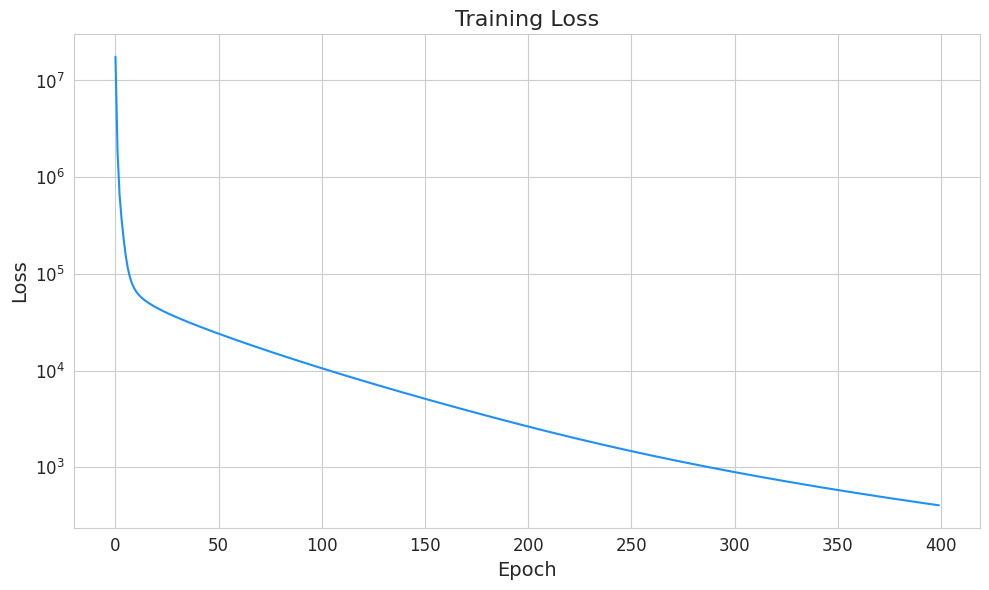

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'losses' is a list containing the training losses

# Set seaborn style
sns.set_style("whitegrid")

# Define a darker shade of blue
custom_color = (0.12, 0.56, 0.98)  # Using RGB values for deep blue

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses, color=custom_color)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.tight_layout()

# Save the plot as a PNG file with high DPI
plt.savefig('loss_plot.png', dpi=300)

# Show the plot
plt.show()


#### For visualizing the reconsturction

In [ ]:
import torch

synthetic_data,_,_ = vae(input_data.to(device))

synthetic_data = synthetic_data.cpu()
print(synthetic_data.size())


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid")

# Loop over columns and plot histograms
for col in data.columns:
    plt.figure(figsize=(6, 4),dpi = 120)  # Set smaller figure size

    # Calculate the range of values in your data
    data_range = np.max(data[col]) - np.min(data[col])

    # Calculate the bin width
    bin_width = data_range / 50  # Assuming 50 bins

    # Calculate the number of bins for synthetic data using the same bin width
    num_bins_synthetic = int(data_range / bin_width)

    # Plot histograms with equal bin width and number of bins
    plt.hist(data[col], bins=50, range=(np.min(data[col]), np.max(data[col])), alpha=0.5, color='blue', label='Real', density=True)
    plt.hist(synthetic_data[:, data.columns.get_loc(col)].detach().numpy(), bins=num_bins_synthetic, range=(np.min(data[col]), np.max(data[col])), alpha=0.5, color='orange', label='Synthetic', density=True)

    plt.title(f'Distribution of {col}', fontsize=5)  # Smaller title font size
    plt.xlabel(col, fontsize=5)  # Smaller x-axis label font size
    plt.ylabel('Density', fontsize=5)  # Smaller y-axis label font size
    plt.legend(fontsize=6)  # Smaller legend font size

    # Adjust font sizes for ticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Set grid
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()


torch.Size([2555190, 15])


## Generating data

In this section, we are going to generate synthetic data using our trained Variational Autoencoder (VAE). The process involves two main steps:

1. **Sampling from the Latent Space:** We first sample points from a 100-dimensional normal distribution, denoted as $N(0, I)$, where $0$ is a zero vector (representing the mean of the distribution), $I$ is an identity matrix (representing the covariance of the distribution), and $N$ denotes the normal distribution. This sampled latent space represents the compressed representation of our data.

2. **Decoding the Sampled Points:** The sampled points are then passed through the decoder part of our VAE. The decoder, being a generative model, will transform these compressed representations back to the original data space, effectively generating new synthetic data that has similar statistical properties to our original data.

The resulting synthetic data can then be plotted for visual inspection and further analysis.

In [11]:
sampled_data = torch.randn(2000000, 128, dtype= torch.float32)
# Define batch size
batch_size = 1000

# Total number of samples
total_samples = sampled_data.size(0)

# Initialize an empty list to store generated data batches
generated_data_batches = []

# Iterate over the sampled data in batches
for i in range(0, total_samples, batch_size):
    # Get a batch of sampled data
    sampled_data_batch = sampled_data[i:i+batch_size].float().to(device)
    
    # Generate data for the batch
    generated_data_batch = vae.decoder(sampled_data_batch)
    
    # Move data back to CPU
    generated_data_batch = generated_data_batch.cpu()
    
    # Convert tensor to numpy array and append to the list
    generated_data_batches.append(generated_data_batch.detach().numpy())

# Concatenate the batches along the first dimension
generated_data_np = np.concatenate(generated_data_batches, axis=0)

# Apply inverse transformation
inverse_transformed_data = scaler.inverse_transform(generated_data_np)

data = df_labled 
generated_data = np.round(inverse_transformed_data).astype(int)

## Evaluation of Synthetic Data Generation

The evaluation of synthetic data generation can be broken down into three levels of granularity:

###  - Coarse-grained Evaluation

This level of evaluation focuses on the overall similarity between the synthetic data and the real data. Two key metrics are used:

- **Percentage of Direct Copies:** This metric measures what percentage of the synthetic data is a direct copy of the real data. It helps to understand if the model is merely memorizing the training data.

- **Percentage of Self Copies:** This metric measures what percentage of the synthetic data is a copy of another synthetic data point. It helps to understand the diversity of the generated data.

### - Medium-grained Evaluation

This level of evaluation involves comparing the distribution of the real data versus the synthetic data. Tools like histograms or density plots can be used to visualize and compare the overall distribution of the data.

### - Fine-grained Evaluation

This level of evaluation involves a more detailed comparison of the joint distributions between different features in the real and synthetic data. This can help to understand if the model is capturing the correlations between different features in the data.


## Coarse-grained Evaluation
  
  
#### Percentage of direct copies

In [12]:
import pandas as pd

# Assuming data is your real data and generated_data is your synthetic data
real_df = pd.DataFrame(data)
synth_df = pd.DataFrame(generated_data)

# Concatenate real and synthetic data
total_df = pd.concat([real_df, synth_df])

# Calculate number of duplicates in total, real and synthetic data
dup_total = len(total_df) - len(total_df.drop_duplicates())
dup_real = len(real_df) - len(real_df.drop_duplicates())
dup_synthetic = len(synth_df) - len(synth_df.drop_duplicates())

# Calculate number of copies
copies = dup_total - dup_real - dup_synthetic

print(f"The number of data that is a direct copy of the real data is {copies}")


The number of data that is a direct copy of the real data is 0


#### Percentage of self copies 

In [13]:
# Calculate number of self copies in the synthetic data
self_copies = dup_synthetic - len(synth_df[synth_df.duplicated(keep=False)])

# Calculate the percentage of self copies
percentage_self_copies = (self_copies / len(synth_df)) * 100

print(f"The percentage of self copies in the synthetic data is {percentage_self_copies}%")



The percentage of self copies in the synthetic data is 0.0%


##  Medium-grained Evaluation
#### Plotting Generated Data


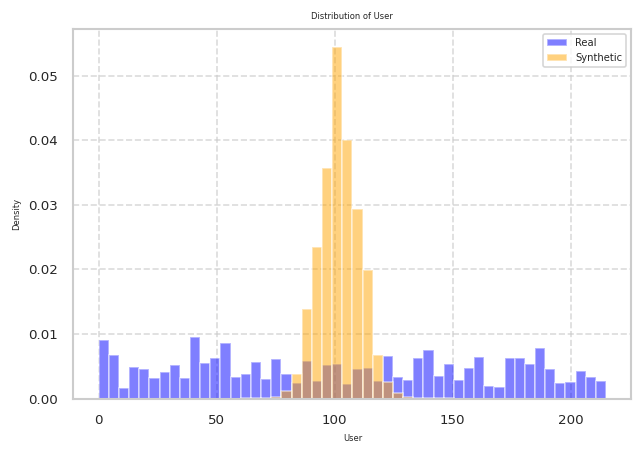

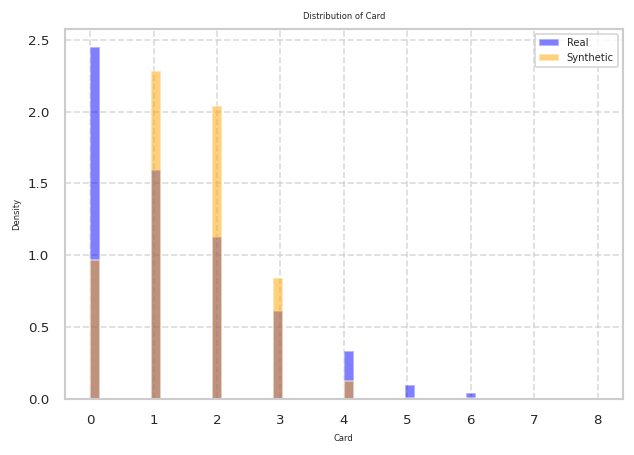

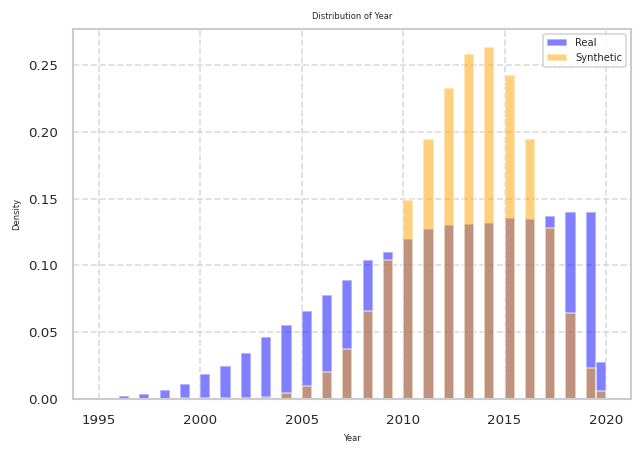

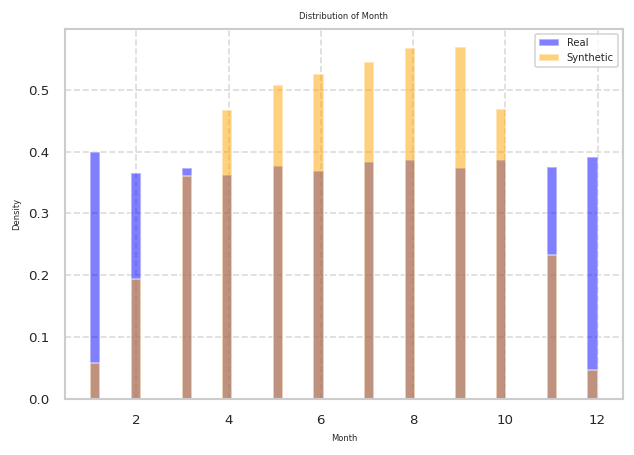

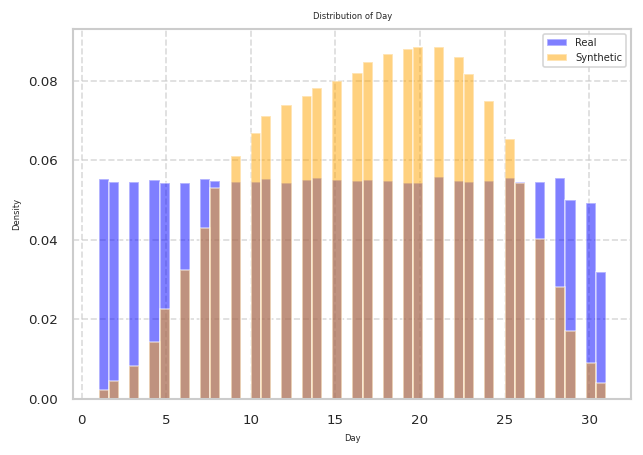

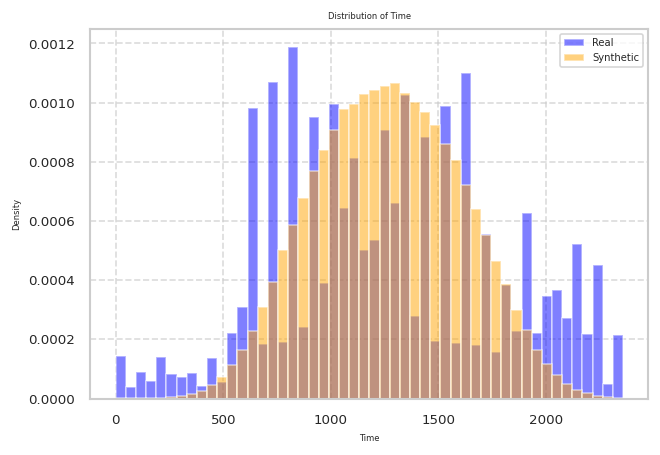

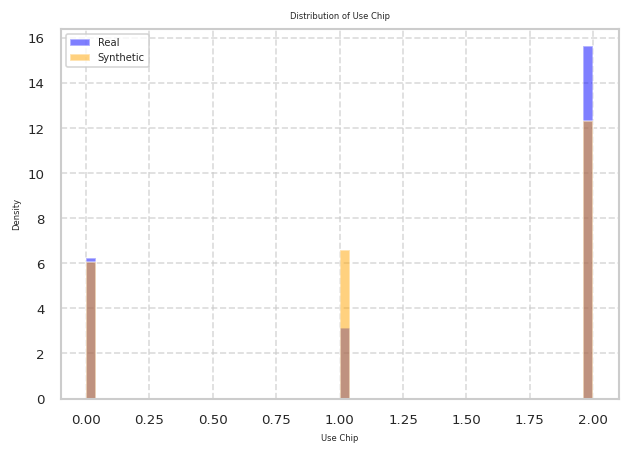

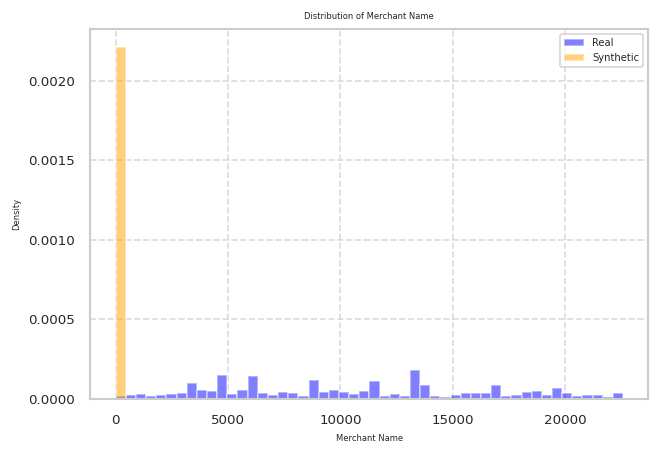

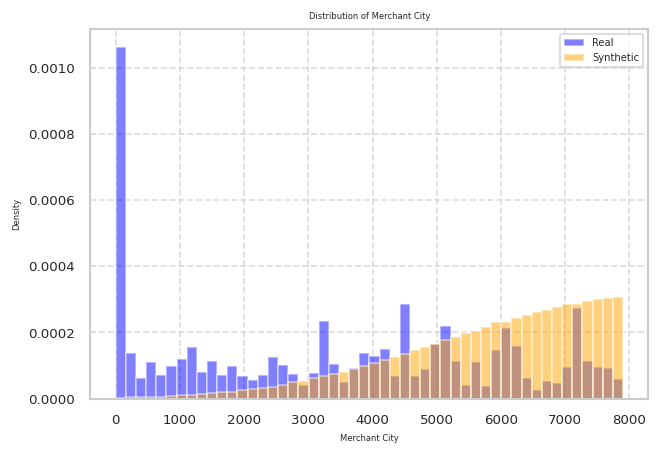

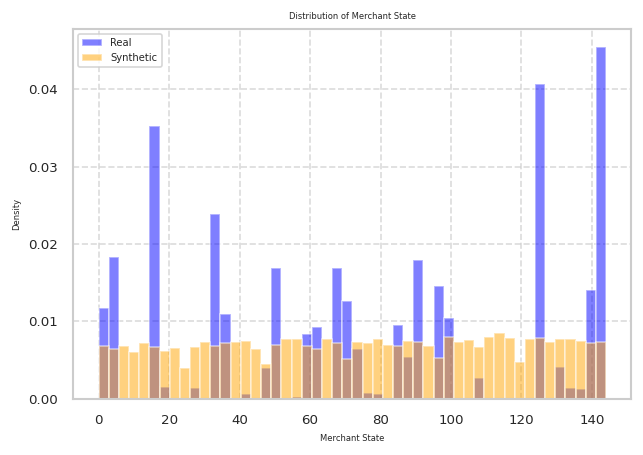

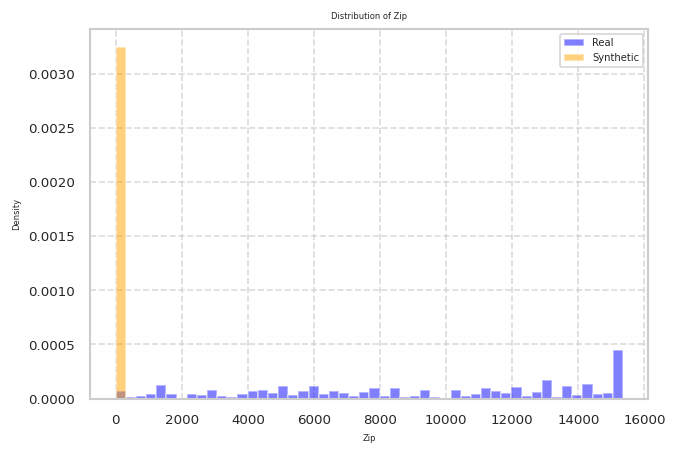

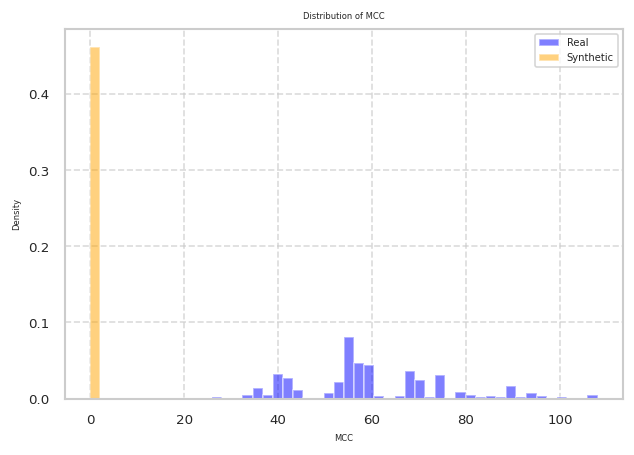

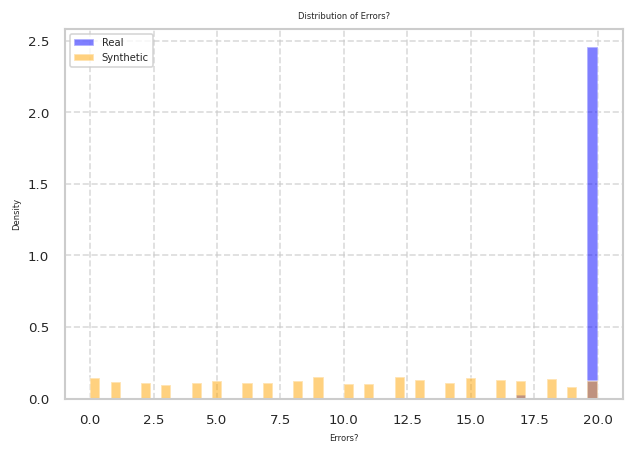

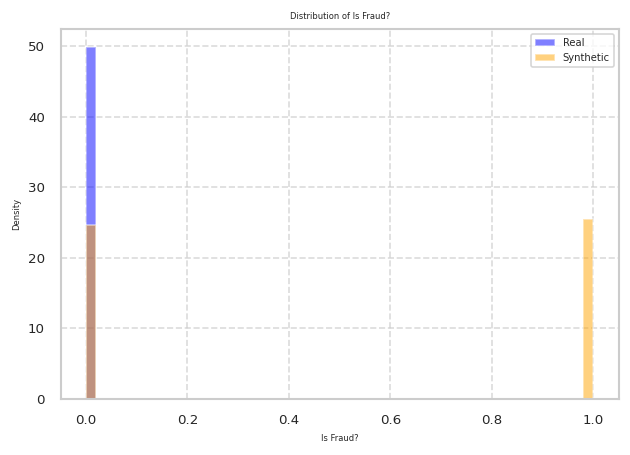

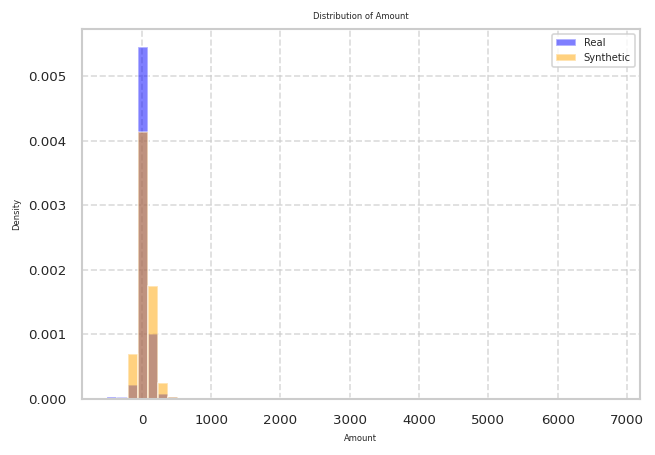

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid")

# Loop over columns and plot histograms
for col in data.columns:
    plt.figure(figsize=(6, 4),dpi = 120)  # Set smaller figure size

    # Calculate the range of values in your data
    data_range = np.max(data[col]) - np.min(data[col])

    # Calculate the bin width
    bin_width = data_range / 50  # Assuming 50 bins

    # Calculate the number of bins for synthetic data using the same bin width
    num_bins_synthetic = int(data_range / bin_width)

    # Plot histograms with equal bin width and number of bins
    plt.hist(data[col], bins=50, range=(np.min(data[col]), np.max(data[col])), alpha=0.5, color='blue', label='Real', density=True)
    plt.hist(generated_data[:, data.columns.get_loc(col)],bins=num_bins_synthetic, range=(np.min(data[col]), np.max(data[col])), alpha=0.5, color='orange', label='Synthetic', density=True)

    plt.title(f'Distribution of {col}', fontsize=5)  # Smaller title font size
    plt.xlabel(col, fontsize=5)  # Smaller x-axis label font size
    plt.ylabel('Density', fontsize=5)  # Smaller y-axis label font size
    plt.legend(fontsize=6)  # Smaller legend font size

    # Adjust font sizes for ticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Set grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure as a high-res PNG
    plt.savefig(f'{col}_distribution.png', dpi=300)

    plt.show()


In [ ]:
# def inverse_transform_with_default(label_encoder, labels, default_value='mod'):
#     try:
#         return label_encoder.inverse_transform(labels)
#     except ValueError:
#         # Create an array to hold the results
#         result = np.empty_like(labels, dtype=object)
        
#         # Get the set of original classes
#         original_classes = set(label_encoder.classes_)
        
#         # Iterate over labels and inverse transform if possible
#         for idx, label in enumerate(labels):
#             if label in original_classes:
#                 result[idx] = label_encoder.inverse_transform([label])
#             else:
#                 result[idx] = default_value
#         return result

# # Usage
# inverted = inverse_transform_with_default(label_encoder, generated_data[6554], default_value='mod')
# print("Inverse Transformed Generated Data:")
# print(inverted)
